In [2]:
import uproot
import pandas as pd
import awkward as ak
import numpy as np

In [41]:
with uproot.open("../data/gntp.3.gtrac.root") as f:
    # Read all pdg IDs and polarization vectors from all events as two awkward arrays
    pdg = f["gRooTracker;22/StdHepPdg"].array()
    pol = f["gRooTracker;22/StdHepPolz"].array()
    status = f["gRooTracker;22/StdHepStatus"].array()

In [52]:
print(f"{pdg.type}, {pol.type}, {status.type}")
# identify all particles that are tau leptons and extract their polarization vectors and statuses
tau_mask = pdg == 15
tau_pol = ak.flatten(pol[tau_mask])
tau_status = status[tau_mask]
# Check which statuses are present
print(np.unique(ak.flatten(tau_status), return_counts=True))

print(tau_pol.type)

np.sum(np.all(tau_pol == 0, axis=1))

1000000 * var * int32, 1000000 * var * 3 * float64, 1000000 * var * int32
[[1], [422038]]
422038 * 3 * float64


79679

In [47]:
pd.DataFrame(tau_pol.to_numpy(), columns=["polx", "poly", "polz"])

,polx,poly,polz
0,0.086999,0.008235,-0.996174
1,0.000000,0.000000,0.000000
2,0.132538,0.161835,-0.977877
3,0.179302,0.217577,-0.959433
4,-0.229704,0.083774,-0.969648
...,...,...,...
422033,-0.117234,-0.061026,-0.991228
422034,-0.068113,-0.144505,-0.987157
422035,0.131012,0.122818,-0.983744
422036,0.000000,0.000000,0.000000


In [4]:
taus = pd.read_csv("../data/genie_pol_e10.csv")

In [51]:
np.sum(np.all(taus.loc[:, "polx":"polz"] == 0, axis=1))

79679

In [54]:
assert np.all(np.all(tau_pol == 0, axis=1) == (taus.loc[:, "polx":"polz"] == 0).all(axis=1).values)

## Analyze tau lepton energy loss in ice
Based on events simulated with Geant4

In [61]:
g4_taus = pd.read_csv("../data/geant4_tau_output_e50.csv")

In [62]:
assert (g4_taus.groupby("event_num").count() == 2).all().all()

In [63]:
g4_tau_diff = g4_taus.groupby("event_num").diff().dropna(axis=0).drop("status", axis=1)
g4_tau_diff_sig = g4_tau_diff.loc[(g4_tau_diff != 0).any(axis=1), :].copy()
g4_tau_diff_sig["delta_x"] = (g4_tau_diff_sig["x"]**2 + g4_tau_diff_sig["y"]**2 + g4_tau_diff_sig["z"]**2).pow(0.5)

<Axes: xlabel='moved distance (mm)', ylabel='Frequency'>

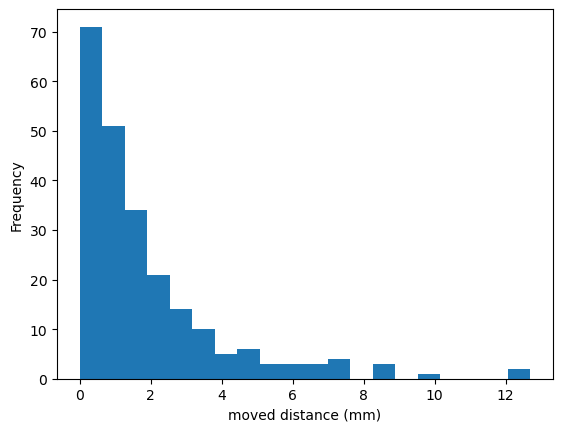

In [64]:
(g4_tau_diff_sig["delta_x"]*1000).plot.hist(bins=20, xlabel="moved distance (mm)")

<Axes: xlabel='energy loss (MeV)', ylabel='Frequency'>

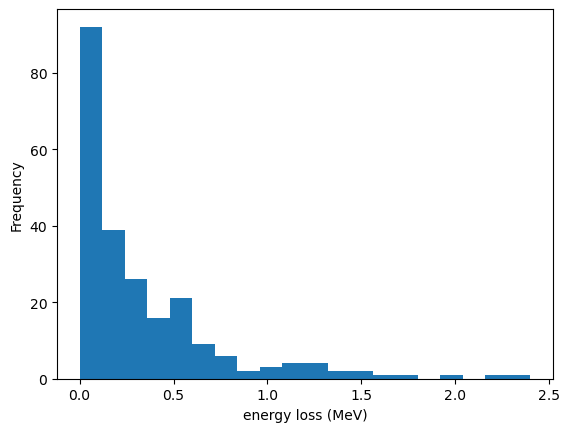

In [65]:
(-g4_tau_diff_sig["E"]*1000).plot.hist(bins=20, xlabel="energy loss (MeV)")

In [66]:
((-g4_tau_diff["E"]*1000) < 1).sum() / len(g4_tau_diff)

0.9971492873218305

## Read all interesting parameters and store to an event file

In [59]:
with uproot.open("../data/gntp.5.gst.root") as f:
    # Read gst/hitnuc
    event_infos = f["gst"].arrays(["iev", "qel", "res", "dis", "cc", "sea", "hitqrk", "xs", "ys", "Q2s", "Ws", "hitnuc", "A", "En", "pxn", "pyn", "pzn", "charm", "Ev", "pxv", "pyv", "pzv"])


In [60]:
ev = event_infos[event_infos["iev"] < 50000]
ev["Mnuc"] = np.sqrt(ev["En"]**2 - ev["pxn"]**2 - ev["pyn"]**2 - ev["pzn"]**2)
ev["event_num"] = ev["iev"]
ev["qel"] = ev["qel"] & ev["cc"]
ev["res"] = ev["res"] & ev["cc"]
ev["dis"] = ev["dis"] & ev["cc"]
ev["atom"] = ev["A"]
ev["Enu"] = ev["Ev"]
ev["pxnu"] = ev["pxv"]
ev["pynu"] = ev["pyv"]
ev["pznu"] = ev["pzv"]

In [61]:
# Convert awkward array to pandas
ev_df = pd.DataFrame(ev.to_numpy(), columns=ev.fields)
ev_df.to_csv("../data/genie_tau_pol_data_gst.csv", index=False)

## Compare gst file values to manual extraction

In [62]:
gst = pd.read_csv("../data/genie_tau_pol_data_gst_f.csv")
gst_int = pd.read_csv("../data/genie_tau_pol_data_gst_f_int.csv")
manual = pd.read_csv("../data/genie_tau_pol_data_e10_1.csv")

In [63]:
non_float_cols = ["qel", "res", "dis", "sea", "charm", "hitqrk", "event_num", "atom", "hitnuc"]
assert (gst.loc[gst["dis"] | gst["res"] | gst["qel"], non_float_cols] == manual.loc[manual["dis"] | manual["res"] | manual["qel"], non_float_cols]).all().all()
assert (gst_int.loc[gst_int["dis"] | gst_int["res"] | gst_int["qel"], non_float_cols] == manual.loc[manual["dis"] | manual["res"] | manual["qel"], non_float_cols]).all().all()

In [64]:
float_cols = ["Mnuc", "xs", "Q2s"]
close_vals = np.isclose(gst.loc[gst["dis"], float_cols], manual.loc[gst["dis"], float_cols], atol=1e-6)
assert close_vals.all().all()
close_vals = np.isclose(gst_int.loc[gst["dis"], float_cols], manual.loc[gst["dis"], float_cols], atol=1e-6)
assert close_vals.all().all()

The extraction method seems to be correct, and all values match

In [65]:
f_close = np.isclose(gst.loc[gst["F1"].notnull(), "F1":"F5"], manual.loc[manual["F1"].notnull(), "F1":"F5"], atol=1e-4).all(axis=1)
f_close_int = np.isclose(gst_int.loc[gst_int["F1"].notnull(), "F1":"F5"], manual.loc[manual["F1"].notnull(), "F1":"F5"], atol=1e-4).all(axis=1)

In [66]:
gst.loc[gst["F1"].notnull(), :][~f_close].drop(["iev", "En", "pxn", "pyn", "pzn"], axis=1)

,cc,sea,hitqrk,xs,Q2s,hitnuc,A,charm,Ev,Mnuc,event_num,qel,res,dis,atom,F1,F2,F3,F4,F5
1,True,False,1,0.431447,52.596432,2112,16,False,100.0,0.918393,1,False,False,True,16,0.611472,0.534678,1.241390,0.0,1.241390
4,True,False,1,0.356973,5.530777,2112,16,False,100.0,0.885697,4,False,False,True,16,1.199530,0.887138,2.483910,0.0,2.483910
5,True,False,1,0.234142,38.530999,2212,16,False,100.0,0.906232,5,False,False,True,16,0.929012,0.455120,1.937230,0.0,1.937230
9,True,False,1,0.508304,80.313765,2112,16,False,100.0,0.921316,9,False,False,True,16,0.324748,0.332537,0.655794,0.0,0.655794
11,True,False,1,0.055564,5.017979,2112,16,False,100.0,0.894275,11,False,False,True,16,5.343950,0.763931,13.045100,0.0,13.045100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,True,False,1,0.181520,2.289143,2112,16,False,100.0,0.893828,49993,False,False,True,16,2.599130,1.189590,6.102090,0.0,6.102090
49994,True,True,3,0.085276,4.227376,2112,16,True,100.0,0.919576,49994,False,False,True,16,0.238472,0.052200,0.578000,0.0,0.578000
49995,True,False,1,0.316624,19.009370,2112,16,False,100.0,0.920764,49995,False,False,True,16,1.385610,0.911258,2.871070,0.0,2.871070
49997,True,False,1,0.296443,41.930283,2112,16,False,100.0,0.912010,49997,False,False,True,16,1.493360,0.914446,3.079740,0.0,3.079740


In [67]:
manual.loc[manual["F1"].notnull(), :][~f_close]

,event_num,qel,res,dis,sea,hitqrk,xs,Q2s,hitnuc,atom,Mnuc,charm,F1,F2,F3,F4,F5
1,1,False,False,True,False,1,0.431447,52.596432,2112,16,0.918393,False,0.611018,0.534281,1.240464,0.0,1.240464
4,4,False,False,True,False,1,0.356973,5.530777,2112,16,0.885697,False,1.194707,0.883572,2.473922,0.0,2.473922
5,5,False,False,True,False,1,0.234142,38.530999,2212,16,0.906232,False,0.928715,0.454975,1.936614,0.0,1.936614
9,9,False,False,True,False,1,0.508304,80.313765,2112,16,0.921316,False,0.324504,0.332288,0.655301,0.0,0.655301
11,11,False,False,True,False,1,0.055564,5.017979,2112,16,0.894275,False,5.352028,0.765086,13.064777,0.0,13.064777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,49993,False,False,True,False,1,0.181520,2.289143,2112,16,0.893828,False,2.590593,1.185687,6.082050,0.0,6.082050
49994,49994,False,False,True,True,3,0.085276,4.227376,2112,16,0.919576,True,0.226624,0.049607,0.549284,0.0,0.549284
49995,49995,False,False,True,False,1,0.316624,19.009370,2112,16,0.920764,False,1.384291,0.910392,2.868342,0.0,2.868342
49997,49997,False,False,True,False,1,0.296443,41.930283,2112,16,0.912010,False,1.492811,0.914110,3.078607,0.0,3.078607


In [69]:
f_close_int.all()

True

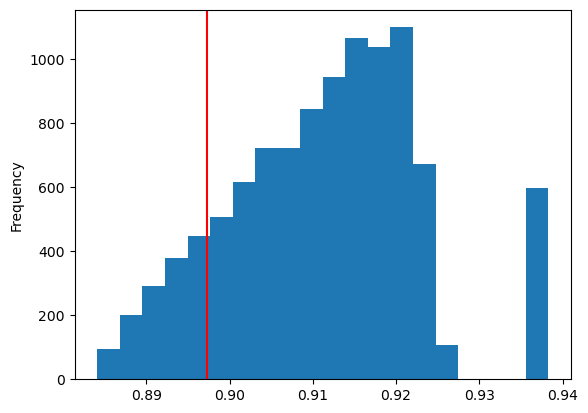

In [90]:
ax = manual.loc[manual["F1"].notnull(), :][f_close]["Mnuc"].plot.hist(bins=20)
ax.axvline(0.89733, color="red")

<Axes: ylabel='Frequency'>

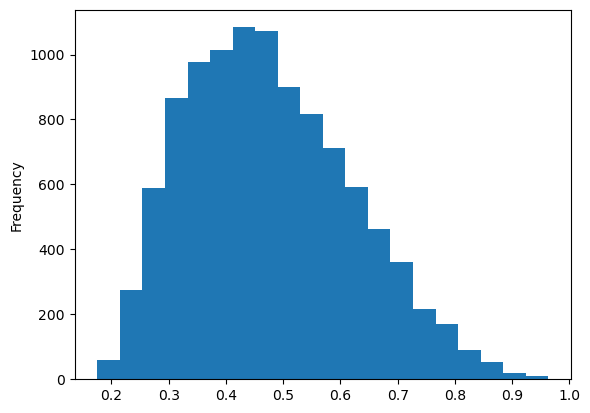

In [91]:
manual.loc[manual["F1"].notnull(), :][f_close]["xs"].plot.hist(bins=20)